# Hangman RL

In [1]:
from tqdm import trange
import tensorflow as tf
import numpy as np
from hangman import Environment, Agent

In [2]:
# parallel environments over which we will play
# we use multiple environments so that samples from them are time-uncorrelated
envs = [Environment("dataset.txt") for _ in range(1024)]

loading dataset


In [4]:
# we build the agent, passing the first env as example from which take the word list
agent = Agent(envs[0], batch_size=len(envs), actor_rep=1)

## Training of the main agent

Takes 5/10 minutes depending on the PC

In [6]:
rewards_history = [0]
EPOCHS = 5000
for e in range(EPOCHS):
    if e % 50 == 0:
        print(f"{e}/{EPOCHS} - {np.mean(rewards_history[-30:]) or 0}", end="\n")
    states = []
    masks = []
    # get states and masks for each env
    for env in envs:
        states.append(agent.state(env))
        masks.append(agent.mask(env))
    states = np.array(states)
    masks = np.array(masks)

    # calculate pi(a|s)
    original_probs = agent.actor(states)
    probs = original_probs * masks
    probs = probs / tf.reduce_sum(probs, axis=-1, keepdims=True)
    # sample word to guess
    samples = tf.random.categorical(tf.math.log(probs), 1)[:, 0]

    rewards = []
    dones = []
    # act on each env and collect reward/done
    for sample, env in zip(samples, envs):
        d, r = env.act(agent.int_to_only_letter(env, sample))
        rewards.append(r)
        dones.append(d)

    rewards = np.array(rewards)
    dones = np.array(dones)
    # collect new states, to use for the learning of the agent
    new_states = []
    for env in envs:
        new_states.append(agent.state(env))
    new_states = np.array(new_states)
    # learning for the agent
    agent.learn(states, new_states, samples, rewards, dones, masks)

    # collect history of rewards
    if e > 50: rewards_history.append(np.mean(rewards))


0/5000 - 0
50/5000 - 0
100/5000 - 0.08209635416666666
150/5000 - 0.08235677083333333
200/5000 - 0.083984375
250/5000 - 0.08447265625
300/5000 - 0.08440755208333334
350/5000 - 0.08479817708333333
400/5000 - 0.0853515625
450/5000 - 0.08570963541666667
500/5000 - 0.08743489583333333
550/5000 - 0.08893229166666666
600/5000 - 0.08857421875
650/5000 - 0.08880208333333334
700/5000 - 0.08876953125
750/5000 - 0.08857421875
800/5000 - 0.08958333333333333
850/5000 - 0.08977864583333334
900/5000 - 0.09010416666666667
950/5000 - 0.08942057291666666
1000/5000 - 0.090234375
1050/5000 - 0.09016927083333333
1100/5000 - 0.08968098958333333
1150/5000 - 0.09069010416666666
1200/5000 - 0.09013671875
1250/5000 - 0.09029947916666667
1300/5000 - 0.09078776041666667
1350/5000 - 0.09013671875
1400/5000 - 0.08974609375
1450/5000 - 0.09026692708333334
1500/5000 - 0.09016927083333333
1550/5000 - 0.09013671875
1600/5000 - 0.090234375
1650/5000 - 0.09078776041666667
1700/5000 - 0.09091796875
1750/5000 - 0.0897786458

## Training of a random agent (baseline)

In [7]:
envs = [Environment("dataset.txt") for _ in range(256)]
shape = (256, len(envs[0].only_letters_list))
random_rewards_history = []
for _ in trange(1000):
    masks = []
    for env in envs:
        masks.append(agent.mask(env))
    masks = np.array(masks)
    # uniform distribution over letters
    probs = np.ones(shape)/shape[-1]
    probs = probs * masks
    probs = probs * tf.linalg.norm(probs, ord=1, axis=-1)[0]
    samples = tf.random.categorical(tf.math.log(probs), 1)[:, 0]
    rewards = []
    for sample, env in zip(samples, envs):
        d,r = env.act(agent.int_to_only_letter(env, sample))
        rewards.append(r)
    rewards = np.array(rewards)
    random_rewards_history.append(np.mean(rewards))

100%|██████████| 1000/1000 [00:15<00:00, 65.68it/s]


## Training results

Text(0, 0.5, 'rewards')

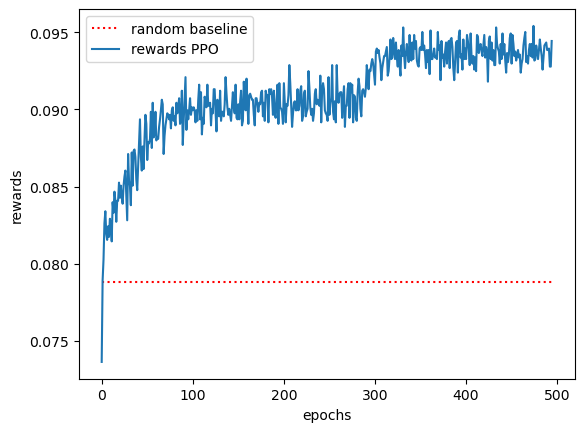

In [8]:
import matplotlib.pyplot as plt
N = 10
rewards_history_ = np.reshape(rewards_history[:len(rewards_history) // N * N], (-1, N)).mean(axis=-1)
plt.hlines(np.mean(random_rewards_history), 0, len(rewards_history_), color="red", linestyles="dotted")
plt.plot(rewards_history_)
plt.legend(["random baseline", "rewards PPO"])
plt.xlabel("epochs")
plt.ylabel("rewards")